## Setup

https://www.youtube.com/watch?v=YUEbnm8M3-c

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [0]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

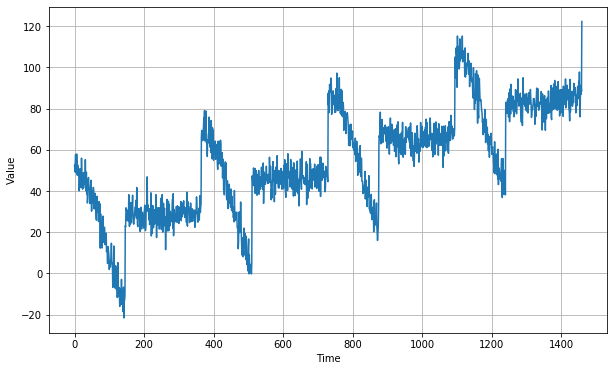

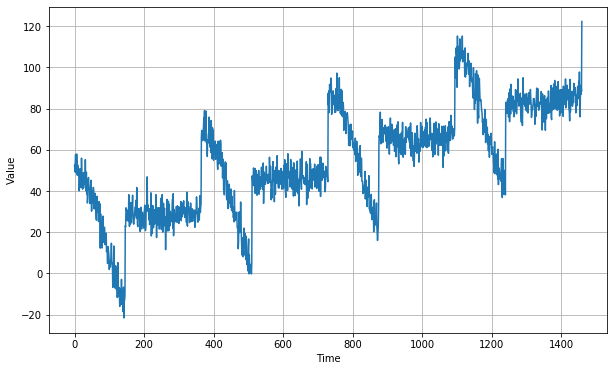

In [0]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Preprocessing With 1D-Convolutional Layers

In [0]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 7s 883ms/step - loss: 87.4947 - mae: 88.3356
Epoch 2/100
8/8 [==============================] - 0s 37ms/step - loss: 86.8595 - mae: 87.6112
Epoch 3/100
8/8 [==============================] - 0s 35ms/step - loss: 86.0590 - mae: 86.4322
Epoch 4/100
8/8 [==============================] - 0s 37ms/step - loss: 84.4440 - mae: 84.8714
Epoch 5/100
8/8 [==============================] - 0s 36ms/step - loss: 82.4501 - mae: 82.9793
Epoch 6/100
8/8 [==============================] - 0s 35ms/step - loss: 80.5387 - mae: 80.7489
Epoch 7/100
8/8 [==============================] - 0s 36ms/step - loss: 77.8250 - mae: 78.2492
Epoch 8/100
8/8 [==============================] - 0s 37ms/step - loss: 75.2095 - mae: 75.6000
Epoch 9/100
8/8 [==============================] - 0s 37ms/step - loss: 72.3287 - mae: 72.9481
Epoch 10/100
8/8 [==============================] - 0s 37ms/step - loss: 69.9495 - mae: 70.4036
Epoch 11/100
8/8 [==============================

[1e-08, 0.0001, 0, 30]

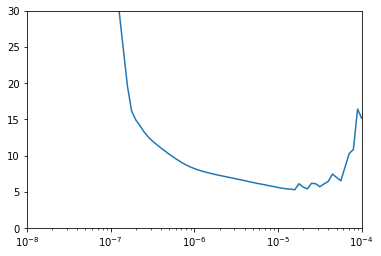

[1e-08, 0.0001, 0, 30]

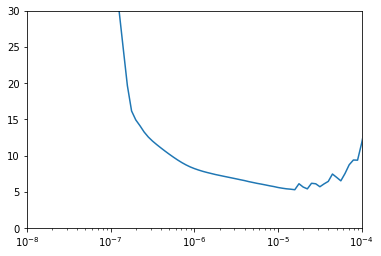

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [0]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 5s 590ms/step - loss: 57.1561 - mae: 58.2706 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
8/8 [==============================] - 0s 51ms/step - loss: 24.1624 - mae: 24.3364 - val_loss: 35.8343 - val_mae: 36.9375
Epoch 3/500
8/8 [==============================] - 0s 52ms/step - loss: 16.7320 - mae: 17.2362 - val_loss: 37.3008 - val_mae: 37.5001
Epoch 4/500
8/8 [==============================] - 0s 59ms/step - loss: 14.4453 - mae: 14.3808 - val_loss: 22.6559 - val_mae: 23.4096
Epoch 5/500
8/8 [==============================] - 0s 54ms/step - loss: 11.1129 - mae: 11.3806 - val_loss: 19.1821 - val_mae: 19.7705
Epoch 6/500
8/8 [==============================] - 0s 57ms/step - loss: 9.3560 - mae: 9.5911 - val_loss: 16.4036 - val_mae: 16.9639
Epoch 7/500
8/8 [==============================] - 0s 54ms/step - loss: 7.9507 - mae: 8.4399 - val_loss: 16.3301 - val_mae: 16.9760
Epoch 8/500
8/8 [==============================] - 0s 57ms/

Epoch 1/500
8/8 [==============================] - 5s 599ms/step - loss: 57.1561 - mae: 58.2706 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
8/8 [==============================] - 0s 51ms/step - loss: 24.1624 - mae: 24.3364 - val_loss: 35.8343 - val_mae: 36.9375
Epoch 3/500
8/8 [==============================] - 0s 50ms/step - loss: 16.7320 - mae: 17.2362 - val_loss: 37.3008 - val_mae: 37.5001
Epoch 4/500
8/8 [==============================] - 0s 59ms/step - loss: 14.4453 - mae: 14.3808 - val_loss: 22.6559 - val_mae: 23.4096
Epoch 5/500
8/8 [==============================] - 0s 57ms/step - loss: 11.1129 - mae: 11.3806 - val_loss: 19.1821 - val_mae: 19.7705
Epoch 6/500
8/8 [==============================] - 0s 58ms/step - loss: 9.3560 - mae: 9.5911 - val_loss: 16.4036 - val_mae: 16.9639
Epoch 7/500
8/8 [==============================] - 0s 57ms/step - loss: 7.9507 - mae: 8.4399 - val_loss: 16.3301 - val_mae: 16.9760
Epoch 8/500
8/8 [==============================] - 0s 56ms/

In [0]:
model = keras.models.load_model("my_checkpoint.h5")

In [0]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

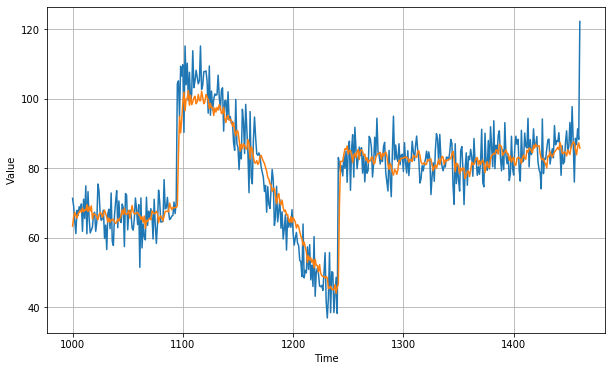

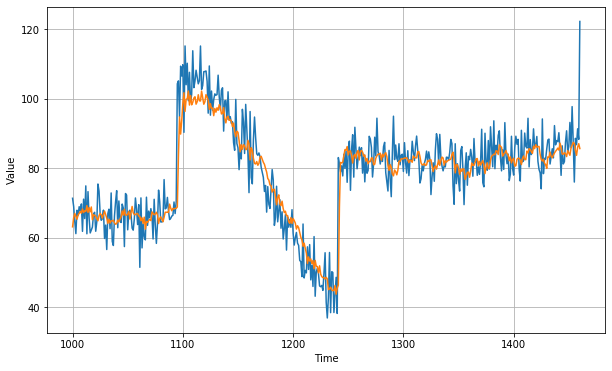

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [0]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

4.875023

4.8642445

## Fully Convolutional Forecasting using the WaveNet model

In [0]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()                           # WaveNet model
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

[0.0001, 0.1, 0, 30]

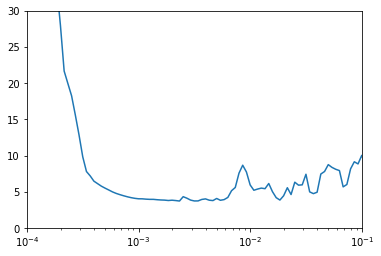

[0.0001, 0.1, 0, 30]

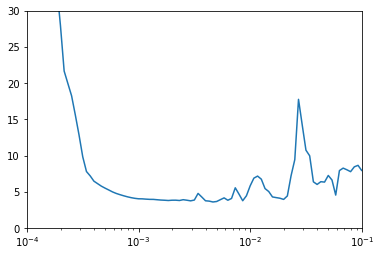

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [0]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

In [0]:
model = keras.models.load_model("my_checkpoint.h5")

In [0]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

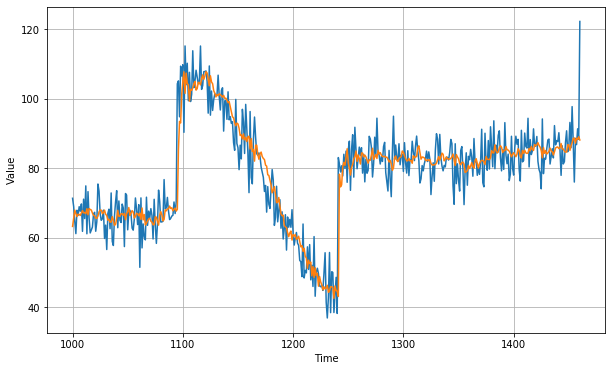

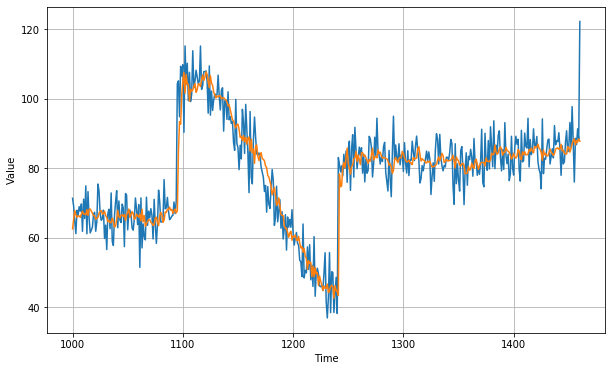

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [0]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.57378

4.5577474

This is the best result from ML without removing seasonality and trends!!!!